### Calculate global tropospheric burdens and NH/SH air mass averaged tropospheric OH ratio

In [1]:
import datetime
import warnings
from pathlib import Path

import iris
import iris.coord_categorisation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from pandas.plotting import register_matplotlib_converters
from scipy import stats

In [2]:
from util_commons import EXPERIMENTS, GASES
from util_mypaths import path_to_processed, path_to_raw, path_to_results
from util_plot_func import use_draft_style

In [3]:
warnings.filterwarnings("ignore", module="iris")
register_matplotlib_converters()  # for tstamps
use_draft_style()

In [4]:
# Switches
exp = "FULL"
trop_def = "chemical"  # diagnostic or chemical
S60N60 = False  # True or False

In [5]:
# Load data
path_to_exp = path_to_processed / EXPERIMENTS[exp]
o3 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_o3.nc"))
oh = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_oh.nc"))
ch4 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_ch4.nc"))
temp = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_temp.nc"))
air_mass = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_air_mass.nc"))
gridbox_vol = iris.load_cube(str(path_to_raw / "ukca_n48_l60_geovol.nc"), "vol_theta")
air_mass.units = "kg"
gridbox_vol.units = "m3"
if exp in ["CHEM", "MARI", "FIRE", "FULL"]:
    meono2 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_meono2.nc"))
    etono2 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_etono2.nc"))
    nprono2 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_nprono2.nc"))
    iprono2 = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_iprono2.nc"))
    iprono2.units = "kg kg-1"

In [6]:
# Define troposphere
if trop_def == "diagnostic":
    # Use tropospheric mask fraction [unitless]
    trop_mask = iris.load_cube(str(path_to_exp / f"{EXPERIMENTS[exp]}_trop_mask.nc"))
    trop_tex = "tropospheric mask fraction"
    trop_str = "tropdiag"
elif trop_def == "chemical":
    # One where O3 is less than 125 ppb
    molar_mass_air = iris.coords.AuxCoord(GASES["air"]["molar_mass"], units="g mol-1")
    molar_mass_o3 = iris.coords.AuxCoord(GASES["o3"]["molar_mass"], units="g mol-1")
    coeff_o3 = molar_mass_air.points[0] / molar_mass_o3.points[0] * 1e9
    trop_mask_bool = np.ma.masked_less(o3.data * coeff_o3, 125).mask
    trop_mask = o3.copy(data=trop_mask_bool)
    trop_mask.rename("chemical troposphere")
    trop_tex = "125 ppb ozonopause"
    trop_str = "tropchem"
    trop_mask.units = "1"

# Define 60S-60N region for comparison with TOAR
if S60N60:
    S60N60_constraint = iris.Constraint(latitude=lambda cell: -60 <= cell <= 60)
    o3 = o3.extract(S60N60_constraint)
    oh = oh.extract(S60N60_constraint)
    ch4 = ch4.extract(S60N60_constraint)
    temp = temp.extract(S60N60_constraint)
    air_mass = air_mass.extract(S60N60_constraint)
    trop_mask = trop_mask.extract(S60N60_constraint)
    gridbox_vol = gridbox_vol.extract(S60N60_constraint)
    if exp in ["CHEM", "MARI", "FIRE", "FULL"]:
        meono2 = meono2.extract(S60N60_constraint)
        etono2 = etono2.extract(S60N60_constraint)
        nprono2 = nprono2.extract(S60N60_constraint)
        iprono2 = iprono2.extract(S60N60_constraint)
    S60N60_tex = "60\u00B0S-60\u00B0N "
    S60N60_str = "60S60N"
else:
    S60N60_tex = ""
    S60N60_str = ""

# Remove the first 2 years as a spin-up
if exp in ["ORIG", "UPDT"]:
    n_yrs = 18
    t0, t1 = 24, 240
else:
    n_yrs = 9
    t0, t1 = 12, 120

In [7]:
# Create datetime coordinate for plotting
cb = o3.copy()
iris.coord_categorisation.add_year(cb, "time", name="year")
iris.coord_categorisation.add_month(cb, "time", name="month")
tstamp0 = datetime.datetime.strptime(
    f"{cb.coord('year').points[0]} " + cb.coord("month").points[0], "%Y %b"
)
tstamp1 = tstamp0 + relativedelta(years=9, months=11)
tstamps = pd.date_range(tstamp0, tstamp1, freq="MS")

In [8]:
def calc_burden(cube, air_mass, trop_mask):
    """Calculate the global tropospheric burden of a selected species in Tg."""
    burden = (cube * air_mass * trop_mask).collapsed(
        ["latitude", "longitude", "level_height"], iris.analysis.SUM
    )
    burden.convert_units("Tg")
    burden.rename(cube.name())
    return burden

In [9]:
o3_burden = calc_burden(o3, air_mass, trop_mask)

In [10]:
def plt_burden_time_series(cube):
    fig, ax = plt.subplots()
    ax.plot(tstamps, cube.data)

    ax.set_title(f"{exp}\n", loc="left", weight="bold")
    ax.set_title(
        f"Tropospheric {GASES[cube.name()]['tex']} burden\n({S60N60_tex}using {trop_tex})",
        loc="right",
    )
    ax.set_xlabel("Time, yr")
    ax.set_ylabel("Tg")
    # Format xticklabels
    iris.coord_categorisation.add_year(cube, "time", name="year")
    iris.coord_categorisation.add_month(cube, "time", name="month")
    plt.draw()
    new_labels = [
        int(i.get_text()) - cube.coord("year").points[0] for i in ax.get_xticklabels(which="both")
    ]
    ax.set_xticklabels(new_labels)

    figname = "_".join(
        [i for i in [EXPERIMENTS[exp], cube.name(), "burden", trop_str, S60N60_str] if i]
    )


#     fig.savefig(path_to_results / EXPERIMENTS[exp] / "metrics" / figname)

/home/maria/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


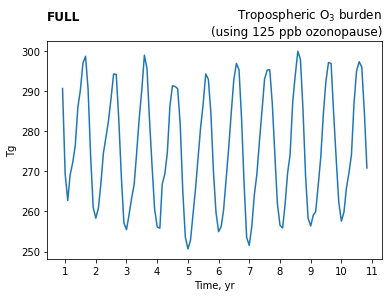

In [11]:
plt_burden_time_series(o3_burden)

In [12]:
break

SyntaxError: 'break' outside loop (<ipython-input-12-6aaf1f276005>, line 4)

#### Tropospheric O3 burden

In [ ]:
# o3_burden_annual_mean.data[[[*range(4)] + [*range(7, 8)]]]

In [ ]:
# o3_burden_annual_mean_xojng = o3_burden_annual_mean
# %store -r o3_burden_annual_mean_xojnd

In [ ]:
# p = stats.shapiro(o3_burden_annual_mean_xojng - o3_burden_annual_mean_xojnd)[1]
# print(p)
# if p > 0.05:
#     print(stats.ttest_rel(o3_burden_annual_mean_xojng, o3_burden_annual_mean_xojnd)[1])
# else:
#     print(stats.wilcoxon(o3_burden_annual_mean_xojng, o3_burden_annual_mean_xojnd)[1])

In [ ]:
# Calculate annual mean O3 burden
o3_burden_annual_mean = o3_burden[t0:t1].data.reshape(n_yrs, 12).mean(axis=1)
if exp == "FIRE":
    print(
        f"{np.mean(o3_burden_annual_mean.data[[[*range(4)] + [*range(7, 8)]]]):1.2f}\u00B1{np.std(o3_burden_annual_mean.data[[[*range(4)] + [*range(7, 8)]]]):1.2f} Tg"
    )
    print(
        f"{np.mean(o3_burden_annual_mean.data[[[*range(4)] + [*range(7, 8)]]]):1.2f}\u00B1{stats.sem(o3_burden_annual_mean.data[[[*range(4)] + [*range(7, 8)]]]):1.2f} Tg"
    )
else:
    print(
        f"{np.mean(o3_burden_annual_mean.data):1.2f}\u00B1{np.std(o3_burden_annual_mean.data):1.2f} Tg"
    )
    print(
        f"{np.mean(o3_burden_annual_mean.data):1.2f}\u00B1{stats.sem(o3_burden_annual_mean.data):1.2f} Tg"
    )

#### Tropospheric CH4 burden

In [ ]:
# Calculate CH4 burden per month
ch4_burden = (ch4 * air_mass * trop_mask).collapsed(
    ["latitude", "longitude", "level_height"], iris.analysis.SUM
)
ch4_burden.convert_units("Tg")
# Calculate annual mean CH4 burden
ch4_burden_annual_mean = ch4_burden[t0:t1].data.reshape(n_yrs, 12).mean(axis=1)
if exp == "FIRE":
    print(
        f"{np.mean(ch4_burden_annual_mean.data[[[*range(4)] + [*range(7, 8)]]]):1.2f}\u00B1{np.std(ch4_burden_annual_mean.data[[[*range(4)] + [*range(7, 8)]]]):1.2f} Tg"
    )
    print(
        f"{np.mean(ch4_burden_annual_mean.data[[[*range(4)] + [*range(7, 8)]]]):1.2f}\u00B1{stats.sem(ch4_burden_annual_mean.data[[[*range(4)] + [*range(7, 8)]]]):1.2f} Tg"
    )
else:
    print(
        f"{np.mean(ch4_burden_annual_mean.data):1.2f}\u00B1{np.std(ch4_burden_annual_mean.data):1.2f} Tg"
    )
    print(
        f"{np.mean(ch4_burden_annual_mean.data):1.2f}\u00B1{stats.sem(ch4_burden_annual_mean.data):1.2f} Tg"
    )

In [ ]:
# ch4_burden_annual_mean_xojng = ch4_burden_annual_mean
# %store -r ch4_burden_annual_mean_xojnd

In [ ]:
# p = stats.shapiro(ch4_burden_annual_mean_xojng - ch4_burden_annual_mean_xojnd)[1]
# print(p)
# if p > 0.05:
#     print(stats.ttest_rel(ch4_burden_annual_mean_xojng, ch4_burden_annual_mean_xojnd)[1])
# else:
#     print(stats.wilcoxon(ch4_burden_annual_mean_xojng, ch4_burden_annual_mean_xojnd)[1])

In [ ]:
fig, ax = plt.subplots()
ax.plot(tstamps, ch4_burden.data)
ax.set_title(f"{exp}\n", loc="left", weight="bold")
ax.set_xlabel("Time, yr")
ax.set_ylabel("Tg")
# Format xticklabels
plt.draw()  # force ticklabels to be generated
new_labels = [
    int(i.get_text()) - cb.coord("year").points[0] for i in ax.get_xticklabels(which="both")
]
ax.set_xticklabels(new_labels)
if trop_def == "chemical" and S60N60:
    ax.set_title(
        "Tropospheric $CH_4$ burden\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)", loc="right"
    )
    fig.savefig(path_to_figs / f"{job}_ch4_burden_chemtrop_60S60N.png")
if trop_def == "chemical" and not S60N60:
    ax.set_title("Tropospheric $CH_4$ burden\n(using 125 ppb ozonopause)", loc="right")
    fig.savefig(path_to_figs / f"{job}_ch4_burden_chemtrop.png")

#### CH4 lifetime

In [ ]:
# Constants
k_ch4_oh = temp.copy(data=1.85e-12 * np.exp(-1690 / temp.data))
k_ch4_oh.rename("CH4+OH reaction rate coefficient")
k_ch4_oh.units = "cm3 s-1"
molar_mass_oh = iris.coords.AuxCoord(17.007, units="g mol-1")
molar_mass_ch4 = iris.coords.AuxCoord(16.0425, units="g mol-1")
avogadro_number = iris.coords.AuxCoord(6.022 * 1e23, units="mol-1", long_name="avogadro_number")
# Find number of OH and CH4 molecules per grid box in the troposphere (tropospheric burden in molecules, not kg)
oh_molecules_per_gridbox = oh * air_mass * trop_mask / molar_mass_oh * avogadro_number
ch4_molecules_per_gridbox = ch4 * air_mass * trop_mask / molar_mass_ch4 * avogadro_number
## Prepare gridbox_vol cube for later multiplication by oh_molecules_per_gridbox cube
# Get rid of time coordinate
gridbox_vol = iris.util.squeeze(gridbox_vol)
gridbox_vol.remove_coord("t")
# Copy oh_molecules_per_gridbox metadata to gridbox_vol cube
_var_name, _units = gridbox_vol.var_name, gridbox_vol.units
gridbox_vol = oh_molecules_per_gridbox[0, ...].copy(data=gridbox_vol.data)
gridbox_vol.rename(_var_name)
gridbox_vol.units = _units
gridbox_vol.remove_coord("forecast_reference_time")
# Calculate CH4 loss in molecules s-1
loss_ch4_oh = k_ch4_oh * ch4_molecules_per_gridbox * oh_molecules_per_gridbox / gridbox_vol
# Calculate CH4 lifetime
volume_sum = (["latitude", "longitude", "level_height"], iris.analysis.SUM)
ch4_lifetime = ch4_molecules_per_gridbox.collapsed(*volume_sum) / loss_ch4_oh.collapsed(*volume_sum)
ch4_lifetime.convert_units("360 day")
# Calculate annual mean CH4 lifetime
ch4_lifetime_annual_mean = ch4_lifetime[t0:t1].data.reshape(n_yrs, 12).mean(axis=1)
if exp == "FIRE":
    print(
        f"{np.mean(ch4_lifetime_annual_mean.data[[[*range(4)] + [*range(7, 8)]]]):1.3f}\u00B1{np.std(ch4_lifetime_annual_mean.data[[[*range(4)] + [*range(7, 8)]]]):1.3f} yr"
    )
    print(
        f"{np.mean(ch4_lifetime_annual_mean.data[[[*range(4)] + [*range(7, 8)]]]):1.3f}\u00B1{stats.sem(ch4_lifetime_annual_mean.data[[[*range(4)] + [*range(7, 8)]]]):1.3f} yr"
    )
else:
    print(
        f"{np.mean(ch4_lifetime_annual_mean.data):1.3f}\u00B1{np.std(ch4_lifetime_annual_mean.data):1.3f} yr"
    )
    print(
        f"{np.mean(ch4_lifetime_annual_mean.data):1.3f}\u00B1{stats.sem(ch4_lifetime_annual_mean.data):1.3f} yr"
    )

In [ ]:
fig, ax = plt.subplots()
ax.plot(tstamps, ch4_lifetime.data)
ax.set_title(f"{exp}\n", loc="left", weight="bold")
ax.set_xlabel("Time, yr")
ax.set_ylabel("yr")
# Format xticklabels
plt.draw()  # force ticklabels to be generated
new_labels = [
    int(i.get_text()) - cb.coord("year").points[0] for i in ax.get_xticklabels(which="both")
]
ax.set_xticklabels(new_labels)
if trop_def == "chemical" and S60N60:
    ax.set_title(
        "Tropospheric $CH_4$ lifetime\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)", loc="right"
    )
    fig.savefig(path_to_figs / f"{job}_ch4_lifetime_chemtrop_60S60N.png")
if trop_def == "chemical" and not S60N60:
    ax.set_title("Tropospheric $CH_4$ lifetime\n(using 125 ppb ozonopause)", loc="right")
    fig.savefig(path_to_figs / f"{job}_ch4_lifetime_chemtrop.png");

#### NH/SH air mass averaged tropospheric OH ratio

In [ ]:
# Calculate OH in molecules per cm3
oh_molecules_per_cm3 = oh_molecules_per_gridbox / gridbox_vol
oh_molecules_per_cm3.convert_units("cm-3")
# Weight OH in each hemisphere by mass of air in each hemisphere
nh_constraint = iris.Constraint(latitude=lambda x: x >= 0)
sh_constraint = iris.Constraint(latitude=lambda x: x <= 0)
averaging_args = (["longitude", "latitude", "level_height"], iris.analysis.MEAN)
oh_nh = (oh_molecules_per_cm3 * air_mass).extract(nh_constraint).collapsed(
    *averaging_args
) / air_mass.extract(nh_constraint).collapsed(*averaging_args)
oh_sh = (oh_molecules_per_cm3 * air_mass).extract(sh_constraint).collapsed(
    *averaging_args
) / air_mass.extract(sh_constraint).collapsed(*averaging_args)
# Calculate annual mean OH ratio
oh_nh_annual_mean = oh_nh.data[t0:t1].reshape(n_yrs, 12).mean(axis=1)
oh_sh_annual_mean = oh_sh.data[t0:t1].reshape(n_yrs, 12).mean(axis=1)
if exp == "FIRE":
    print(
        f"{np.mean(oh_nh_annual_mean[[[*range(4)] + [*range(7, 8)]]]/oh_sh_annual_mean[[[*range(4)] + [*range(7, 8)]]]):1.3f}\u00B1{np.std(oh_nh_annual_mean[[[*range(4)] + [*range(7, 8)]]]/oh_sh_annual_mean[[[*range(4)] + [*range(7, 8)]]]):1.3f}"
    )
    print(
        f"{np.mean(oh_nh_annual_mean[[[*range(4)] + [*range(7, 8)]]]/oh_sh_annual_mean[[[*range(4)] + [*range(7, 8)]]]):1.3f}\u00B1{stats.sem(oh_nh_annual_mean[[[*range(4)] + [*range(7, 8)]]]/oh_sh_annual_mean[[[*range(4)] + [*range(7, 8)]]]):1.3f}"
    )
else:
    print(
        f"{np.mean(oh_nh_annual_mean/oh_sh_annual_mean):1.3f}\u00B1{np.std(oh_nh_annual_mean/oh_sh_annual_mean):1.3f}"
    )
    print(
        f"{np.mean(oh_nh_annual_mean/oh_sh_annual_mean):1.3f}\u00B1{stats.sem(oh_nh_annual_mean/oh_sh_annual_mean):1.3f}"
    )

In [ ]:
# Plot annual mean ratio of OH in the Northern Hemisphere to OH in the Southern Hemisphere
fig, ax = plt.subplots()
ax.bar(np.arange(1, n_yrs + 1), oh_nh_annual_mean / oh_sh_annual_mean)
ax.set_title(f"{exp}\n", loc="left", weight="bold")
ax.set_xlabel("Time, years")
if trop_def == "chemical" and S60N60:
    ax.set_title(
        "NH/SH annual mean tropospheric OH ratio\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)",
        loc="right",
    )
    fig.savefig(path_to_figs / f"{job}_oh_ratio_annual_mean_airmass_averaged_chemtrop_60S60N.png")
if trop_def == "chemical" and not S60N60:
    ax.set_title("NH/SH annual mean tropospheric OH ratio\n(using 125 ppb ozonopause)", loc="right")
    fig.savefig(path_to_figs / f"{job}_oh_ratio_annual_mean_airmass_averaged_chemtrop.png");

In [ ]:
# # SSAN - BASE
# print(272.50 - 271.89)
# print(4357.49 - 4367.93)
# print(9.652 - 9.700)
# print(1.364 - 1.367)

In [ ]:
# # CHEM - BASE
# print(273.19 - 271.89)
# print(4355.96 - 4367.93)
# print(9.634 - 9.700)
# print(1.358 - 1.367)

Experiment & \ce{O3}         & \ce{CH4}        & $\tau_{\ce{CH4}}$ & NH/SH OH     \\
SSAN       & 272.50 (0.30)   & 4357.49 (26.38) & 9.652 (0.037)     & 1.364 (0.004)\\
BASE       & 271.89 (0.47)   & 4367.93 (25.79) & 9.700 (0.027)     & 1.367 (0.005)\\
CHEM       & 273.19 (0.24)   & 4355.96 (24.35) & 9.634 (0.031)     & 1.358 (0.003)\\
MARI       & 274.47 (0.49)   & 4343.19 (24.91) & 9.560 (0.026)     & 1.340 (0.005)\\
FIRE       & 272.99 (0.46)   & 4349.43 (51.08) & 9.640 (0.051)     & 1.366 (0.006)\\
FULL       & 274.85 (0.50)   & 4340.52 (23.19) & 9.549 (0.024)     & 1.345 (0.005)\\

In [ ]:
print("CHEM - BASE O3 burden")
print("abs diff", 273.19 - 271.89)
print("rel diff", (273.19 - 271.89) * 100 / 271.89)
print("abs err", np.sqrt(0.47 ** 2 + 0.24 ** 2))
print("rel err", np.sqrt(0.47 ** 2 + 0.24 ** 2) * 100 / 271.89)

In [ ]:
print("CHEM - BASE CH4 lifetime")
print("abs diff", 9.634 - 9.700)
print("rel diff", (9.634 - 9.700) * 100 / 9.700)
print("abs err", np.sqrt(0.027 ** 2 + 0.031 ** 2))
print("rel err", np.sqrt(0.027 ** 2 + 0.031 ** 2) * 100 / 9.700)

In [ ]:
print("MARI - BASE O3 burden")
print("abs diff", 274.47 - 271.89)
print("rel diff", (274.47 - 271.89) * 100 / 271.89)
print("abs err", np.sqrt(0.47 ** 2 + 0.49 ** 2))
print("rel err", np.sqrt(0.47 ** 2 + 0.49 ** 2) * 100 / 271.89)

In [ ]:
print("MARI - BASE CH4 lifetime")
print("abs diff", 9.560 - 9.700)
print("rel diff", (9.560 - 9.700) * 100 / 9.700)
print("abs err", np.sqrt(0.027 ** 2 + 0.026 ** 2))
print("rel err", np.sqrt(0.027 ** 2 + 0.026 ** 2) * 100 / 9.700)

In [ ]:
print("FIRE - SSAN O3 burden")
print("abs diff", 272.99 - 272.50)
print("rel diff", (272.99 - 272.50) * 100 / 272.50)
print("abs err", np.sqrt(0.30 ** 2 + 0.46 ** 2))
print("rel err", np.sqrt(0.30 ** 2 + 0.46 ** 2) * 100 / 272.50)

In [ ]:
print("FIRE - SSAN CH4 lifetime")
print("abs diff", 9.640 - 9.652)
print("rel diff", (9.640 - 9.652) * 100 / 9.652)
print("abs err", np.sqrt(0.037 ** 2 + 0.051 ** 2))
print("rel err", np.sqrt(0.037 ** 2 + 0.051 ** 2) * 100 / 9.652)

In [ ]:
print("FULL - BASE O3 burden")
print("abs diff", 274.85 - 271.89)
print("rel diff", (274.85 - 271.89) * 100 / 271.89)
print("abs err", np.sqrt(0.47 ** 2 + 0.50 ** 2))
print("rel err", np.sqrt(0.47 ** 2 + 0.50 ** 2) * 100 / 271.89)

In [ ]:
print("FULL - BASE CH4 lifetime")
print("abs diff", 9.549 - 9.700)
print("rel diff", (9.549 - 9.700) * 100 / 9.700)
print("abs err", np.sqrt(0.027 ** 2 + 0.024 ** 2))
print("rel err", np.sqrt(0.027 ** 2 + 0.024 ** 2) * 100 / 9.700)

#### Tropospheric RONO2 burdens

In [ ]:
if exp in ["CHEM", "MARI", "FIRE", "FULL"]:
    # Calculate MeONO2 burden per month
    meono2_burden = (meono2 * air_mass * trop_mask).collapsed(
        ["latitude", "longitude", "level_height"], iris.analysis.SUM
    )
    meono2_burden.convert_units("Gg")
    # Calculate annual mean MeONO2 burden
    meono2_burden_annual_mean = meono2_burden[t0:t1].data.reshape(n_yrs, 12).mean(axis=1)

    etono2_burden = (etono2 * air_mass * trop_mask).collapsed(
        ["latitude", "longitude", "level_height"], iris.analysis.SUM
    )
    etono2_burden.convert_units("Gg")
    etono2_burden_annual_mean = etono2_burden[t0:t1].data.reshape(n_yrs, 12).mean(axis=1)

    nprono2_burden = (nprono2 * air_mass * trop_mask).collapsed(
        ["latitude", "longitude", "level_height"], iris.analysis.SUM
    )
    nprono2_burden.convert_units("Gg")
    nprono2_burden_annual_mean = nprono2_burden[t0:t1].data.reshape(n_yrs, 12).mean(axis=1)

    iprono2_burden = (iprono2 * air_mass * trop_mask).collapsed(
        ["latitude", "longitude", "level_height"], iris.analysis.SUM
    )
    iprono2_burden.convert_units("Gg")
    iprono2_burden_annual_mean = iprono2_burden[t0:t1].data.reshape(n_yrs, 12).mean(axis=1)

    print(
        f"MeONO2 {np.mean(meono2_burden_annual_mean.data):1.2f}\u00B1{np.std(meono2_burden_annual_mean.data):1.2f} Gg"
    )
    print(
        f"EtONO2 {np.mean(etono2_burden_annual_mean.data):1.2f}\u00B1{np.std(etono2_burden_annual_mean.data):1.2f} Gg"
    )
    print(
        f"nPrONO2 {np.mean(nprono2_burden_annual_mean.data):1.3f}\u00B1{np.std(nprono2_burden_annual_mean.data):1.3f} Gg"
    )
    print(
        f"iPrONO2 {np.mean(iprono2_burden_annual_mean.data):1.3f}\u00B1{np.std(iprono2_burden_annual_mean.data):1.3f} Gg"
    )
    print("with standard error")
    print(
        f"MeONO2 {np.mean(meono2_burden_annual_mean.data):1.2f}\u00B1{stats.sem(meono2_burden_annual_mean.data):1.2f} Gg"
    )
    print(
        f"EtONO2 {np.mean(etono2_burden_annual_mean.data):1.2f}\u00B1{stats.sem(etono2_burden_annual_mean.data):1.2f} Gg"
    )
    print(
        f"nPrONO2 {np.mean(nprono2_burden_annual_mean.data):1.3f}\u00B1{stats.sem(nprono2_burden_annual_mean.data):1.3f} Gg"
    )
    print(
        f"iPrONO2 {np.mean(iprono2_burden_annual_mean.data):1.3f}\u00B1{stats.sem(iprono2_burden_annual_mean.data):1.3f} Gg"
    )

In [ ]:
if exp in ["CHEM", "MARI", "FIRE", "FULL"]:
    fig, ax = plt.subplots()
    ax.plot(tstamps, meono2_burden.data)
    ax.set_title(f"{exp}\n", loc="left", weight="bold")
    ax.set_xlabel("Time, yr")
    ax.set_ylabel("Gg")
    plt.draw()
    new_labels = [
        int(i.get_text()) - cb.coord("year").points[0] for i in ax.get_xticklabels(which="both")
    ]
    ax.set_xticklabels(new_labels)
    if trop_def == "chemical" and S60N60:
        ax.set_title(
            "Tropospheric $MeONO_2$ burden\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)",
            loc="right",
        )
        fig.savefig(path_to_figs / f"{job}_meono2_burden_chemtrop_60S60N.png")
    if trop_def == "chemical" and not S60N60:
        ax.set_title("Tropospheric $MeONO_2$ burden\n(using 125 ppb ozonopause)", loc="right")
        fig.savefig(path_to_figs / f"{job}_meono2_burden_chemtrop.png")

In [ ]:
# Remove faulty data from FIRE xojnv
cube = iris.cube.CubeList([meono2_burden[12:72, ...], meono2_burden[84::, ...]]).concatenate()[0]
plt.plot(cube.data)

In [ ]:
if exp in ["CHEM", "MARI", "FIRE", "FULL"]:
    fig, ax = plt.subplots()
    ax.plot(tstamps, etono2_burden.data)
    ax.set_title(f"{exp}\n", loc="left", weight="bold")
    ax.set_xlabel("Time, yr")
    ax.set_ylabel("Gg")
    plt.draw()
    new_labels = [
        int(i.get_text()) - cb.coord("year").points[0] for i in ax.get_xticklabels(which="both")
    ]
    ax.set_xticklabels(new_labels)
    if trop_def == "chemical" and S60N60:
        ax.set_title(
            "Tropospheric $EtONO_2$ burden\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)",
            loc="right",
        )
        fig.savefig(path_to_figs / f"{job}_etono2_burden_chemtrop_60S60N.png")
    if trop_def == "chemical" and not S60N60:
        ax.set_title("Tropospheric $EtONO_2$ burden\n(using 125 ppb ozonopause)", loc="right")
        fig.savefig(path_to_figs / f"{job}_etono2_burden_chemtrop.png")

In [ ]:
if exp in ["CHEM", "MARI", "FIRE", "FULL"]:
    fig, ax = plt.subplots()
    ax.plot(tstamps, nprono2_burden.data)
    ax.set_title(f"{exp}\n", loc="left", weight="bold")
    ax.set_xlabel("Time, yr")
    ax.set_ylabel("Gg")
    plt.draw()
    new_labels = [
        int(i.get_text()) - cb.coord("year").points[0] for i in ax.get_xticklabels(which="both")
    ]
    ax.set_xticklabels(new_labels)
    if trop_def == "chemical" and S60N60:
        ax.set_title(
            "Tropospheric $nPrONO_2$ burden\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)",
            loc="right",
        )
        fig.savefig(path_to_figs / f"{job}_nprono2_burden_chemtrop_60S60N.png")
    if trop_def == "chemical" and not S60N60:
        ax.set_title("Tropospheric $nPrONO_2$ burden\n(using 125 ppb ozonopause)", loc="right")
        fig.savefig(path_to_figs / f"{job}_nprono2_burden_chemtrop.png")

In [ ]:
if exp in ["CHEM", "MARI", "FIRE", "FULL"]:
    fig, ax = plt.subplots()
    ax.plot(tstamps, iprono2_burden.data)
    ax.set_title(f"{exp}\n", loc="left", weight="bold")
    ax.set_xlabel("Time, yr")
    ax.set_ylabel("Gg")
    plt.draw()
    new_labels = [
        int(i.get_text()) - cb.coord("year").points[0] for i in ax.get_xticklabels(which="both")
    ]
    ax.set_xticklabels(new_labels)
    if trop_def == "chemical" and S60N60:
        ax.set_title(
            "Tropospheric $iPrONO_2$ burden\n(60\u00B0S-60\u00B0N using 125 ppb ozonopause)",
            loc="right",
        )
        fig.savefig(path_to_figs / f"{job}_iprono2_burden_chemtrop_60S60N.png")
    if trop_def == "chemical" and not S60N60:
        ax.set_title("Tropospheric $iPrONO_2$ burden\n(using 125 ppb ozonopause)", loc="right")
        fig.savefig(path_to_figs / f"{job}_iprono2_burden_chemtrop.png")

In [ ]:
break

#### Plot surface CH4

In [ ]:
import cartopy.crs as ccrs
import cartopy.util

In [ ]:
ch4_vmr = ch4 * coeff_ch4
ch4_vmr_cyc, lons_cyc = cartopy.util.add_cyclic_point(
    ch4_vmr.data, coord=ch4_vmr.coord("longitude").points
)

In [ ]:
fig, ax = plt.subplots(
    figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0))
)
p0 = ax.pcolormesh(
    lons_cyc,
    ch4_vmr.coord("latitude").points,
    ch4_vmr_cyc[12, 0, ...].data,
    vmin=ch4_vmr_cyc.min(),
    vmax=ch4_vmr_cyc.max(),
    transform=ccrs.PlateCarree(),
)
ax.set_title("Surface $CH_4$, Dec")
ax.coastlines()
fig.colorbar(p0, shrink=0.4, label="")
fig.savefig("/local/mwe14avu/Desktop/new/ch4_surf_12.png", bbox_inches="tight")

In [ ]:
coeff_no2 = (28.97 / 46.006) * 1e9
no2_vmr = no2 * coeff_no2
no2_vmr_cyc, lons_cyc = cartopy.util.add_cyclic_point(
    no2_vmr.data, coord=no2_vmr.coord("longitude").points
)

In [ ]:
fig, ax = plt.subplots(
    figsize=(10, 10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0))
)
p0 = ax.pcolormesh(
    lons_cyc,
    no2_vmr.coord("latitude").points,
    no2_vmr_cyc[0, 0, ...].data,
    transform=ccrs.PlateCarree(),
)  # vmin = a_cyc.min(), vmax = a_cyc.max(),
ax.set_title("Surface something, Dec")
ax.coastlines()
fig.colorbar(p0, shrink=0.4, label="ppb")
fig.savefig("/local/mwe14avu/Desktop/current/smth_surf_dec.png", bbox_inches="tight")